# k-Nearest Neighbor (kNN) exercise
### Ezequiel Aguilar Gonzalez

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


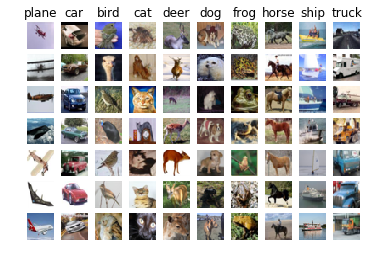

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [10]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [18]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
#print(dists.shape)

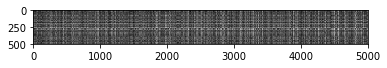

In [20]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [22]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [24]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*:

*Your explanation*:


In [26]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

time 0.0706169605255127
shape (5000, 3072)
shape (5000, 3072)
time 0.07362914085388184
shape (5000, 3072)
shape (5000, 3072)
time 0.07306838035583496
shape (5000, 3072)
shape (5000, 3072)
time 0.07374095916748047
shape (5000, 3072)
shape (5000, 3072)
time 0.07313299179077148
shape (5000, 3072)
shape (5000, 3072)
time 0.0737001895904541
shape (5000, 3072)
shape (5000, 3072)
time 0.07403850555419922
shape (5000, 3072)
shape (5000, 3072)
time 0.07387089729309082
shape (5000, 3072)
shape (5000, 3072)
time 0.07378220558166504
shape (5000, 3072)
shape (5000, 3072)
time 0.07421064376831055
shape (5000, 3072)
shape (5000, 3072)
time 0.07415103912353516
shape (5000, 3072)
shape (5000, 3072)
time 0.07422828674316406
shape (5000, 3072)
shape (5000, 3072)
time 0.07400107383728027
shape (5000, 3072)
shape (5000, 3072)
time 0.07455801963806152
shape (5000, 3072)
shape (5000, 3072)
time 0.07401394844055176
shape (5000, 3072)
shape (5000, 3072)
time 0.08390116691589355
shape (5000, 3072)
shape (5000, 

time 0.07368898391723633
shape (5000, 3072)
shape (5000, 3072)
time 0.0736548900604248
shape (5000, 3072)
shape (5000, 3072)
time 0.07357621192932129
shape (5000, 3072)
shape (5000, 3072)
time 0.0770270824432373
shape (5000, 3072)
shape (5000, 3072)
time 0.07392621040344238
shape (5000, 3072)
shape (5000, 3072)
time 0.07397747039794922
shape (5000, 3072)
shape (5000, 3072)
time 0.07449078559875488
shape (5000, 3072)
shape (5000, 3072)
time 0.07455706596374512
shape (5000, 3072)
shape (5000, 3072)
time 0.07361602783203125
shape (5000, 3072)
shape (5000, 3072)
time 0.07371330261230469
shape (5000, 3072)
shape (5000, 3072)
time 0.0744009017944336
shape (5000, 3072)
shape (5000, 3072)
time 0.07421755790710449
shape (5000, 3072)
shape (5000, 3072)
time 0.0740518569946289
shape (5000, 3072)
shape (5000, 3072)
time 0.07338595390319824
shape (5000, 3072)
shape (5000, 3072)
time 0.07383370399475098
shape (5000, 3072)
shape (5000, 3072)
time 0.07645082473754883
shape (5000, 3072)
shape (5000, 30

time 0.07566356658935547
shape (5000, 3072)
shape (5000, 3072)
time 0.0773015022277832
shape (5000, 3072)
shape (5000, 3072)
time 0.07402563095092773
shape (5000, 3072)
shape (5000, 3072)
time 0.07782387733459473
shape (5000, 3072)
shape (5000, 3072)
time 0.07466650009155273
shape (5000, 3072)
shape (5000, 3072)
time 0.0994265079498291
shape (5000, 3072)
shape (5000, 3072)
time 0.09795069694519043
shape (5000, 3072)
shape (5000, 3072)
time 0.07495427131652832
shape (5000, 3072)
shape (5000, 3072)
time 0.07512211799621582
shape (5000, 3072)
shape (5000, 3072)
time 0.0956888198852539
shape (5000, 3072)
shape (5000, 3072)
time 0.07444548606872559
shape (5000, 3072)
shape (5000, 3072)
time 0.07480883598327637
shape (5000, 3072)
shape (5000, 3072)
time 0.07384204864501953
shape (5000, 3072)
shape (5000, 3072)
time 0.07972240447998047
shape (5000, 3072)
shape (5000, 3072)
time 0.0748300552368164
shape (5000, 3072)
shape (5000, 3072)
time 0.07690834999084473
shape (5000, 3072)
shape (5000, 30

time 0.07561254501342773
shape (5000, 3072)
shape (5000, 3072)
time 0.07435131072998047
shape (5000, 3072)
shape (5000, 3072)
time 0.07424306869506836
shape (5000, 3072)
shape (5000, 3072)
time 0.07460355758666992
shape (5000, 3072)
shape (5000, 3072)
time 0.07490015029907227
shape (5000, 3072)
shape (5000, 3072)
time 0.07465386390686035
shape (5000, 3072)
shape (5000, 3072)
time 0.07577252388000488
shape (5000, 3072)
shape (5000, 3072)
time 0.07449746131896973
shape (5000, 3072)
shape (5000, 3072)
time 0.07454562187194824
shape (5000, 3072)
shape (5000, 3072)
time 0.07503056526184082
shape (5000, 3072)
shape (5000, 3072)
time 0.07461977005004883
shape (5000, 3072)
shape (5000, 3072)
time 0.07490706443786621
shape (5000, 3072)
shape (5000, 3072)
time 0.0773935317993164
shape (5000, 3072)
shape (5000, 3072)
time 0.07508301734924316
shape (5000, 3072)
shape (5000, 3072)
time 0.07472538948059082
shape (5000, 3072)
shape (5000, 3072)
time 0.0740346908569336
shape (5000, 3072)
shape (5000, 

In [27]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [28]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 26.943291 seconds
time 0.07045674324035645
shape (5000, 3072)
shape (5000, 3072)
time 0.07301115989685059
shape (5000, 3072)
shape (5000, 3072)
time 0.07565879821777344
shape (5000, 3072)
shape (5000, 3072)
time 0.0736851692199707
shape (5000, 3072)
shape (5000, 3072)
time 0.0731503963470459
shape (5000, 3072)
shape (5000, 3072)
time 0.07403802871704102
shape (5000, 3072)
shape (5000, 3072)
time 0.07380986213684082
shape (5000, 3072)
shape (5000, 3072)
time 0.07359910011291504
shape (5000, 3072)
shape (5000, 3072)
time 0.07307171821594238
shape (5000, 3072)
shape (5000, 3072)
time 0.07342863082885742
shape (5000, 3072)
shape (5000, 3072)
time 0.07577037811279297
shape (5000, 3072)
shape (5000, 3072)
time 0.07353973388671875
shape (5000, 3072)
shape (5000, 3072)
time 0.07375049591064453
shape (5000, 3072)
shape (5000, 3072)
time 0.07371330261230469
shape (5000, 3072)
shape (5000, 3072)
time 0.07369542121887207
shape (5000, 3072)
shape (5000, 3072)
time 0.0738658905

time 0.07422304153442383
shape (5000, 3072)
shape (5000, 3072)
time 0.10183072090148926
shape (5000, 3072)
shape (5000, 3072)
time 0.09607577323913574
shape (5000, 3072)
shape (5000, 3072)
time 0.07539916038513184
shape (5000, 3072)
shape (5000, 3072)
time 0.07340645790100098
shape (5000, 3072)
shape (5000, 3072)
time 0.07371711730957031
shape (5000, 3072)
shape (5000, 3072)
time 0.07401275634765625
shape (5000, 3072)
shape (5000, 3072)
time 0.07327508926391602
shape (5000, 3072)
shape (5000, 3072)
time 0.0742650032043457
shape (5000, 3072)
shape (5000, 3072)
time 0.07362532615661621
shape (5000, 3072)
shape (5000, 3072)
time 0.07382917404174805
shape (5000, 3072)
shape (5000, 3072)
time 0.07384419441223145
shape (5000, 3072)
shape (5000, 3072)
time 0.0737307071685791
shape (5000, 3072)
shape (5000, 3072)
time 0.07494378089904785
shape (5000, 3072)
shape (5000, 3072)
time 0.07340025901794434
shape (5000, 3072)
shape (5000, 3072)
time 0.07335948944091797
shape (5000, 3072)
shape (5000, 

time 0.07415127754211426
shape (5000, 3072)
shape (5000, 3072)
time 0.0732412338256836
shape (5000, 3072)
shape (5000, 3072)
time 0.07596898078918457
shape (5000, 3072)
shape (5000, 3072)
time 0.07549095153808594
shape (5000, 3072)
shape (5000, 3072)
time 0.07456183433532715
shape (5000, 3072)
shape (5000, 3072)
time 0.0742805004119873
shape (5000, 3072)
shape (5000, 3072)
time 0.07541298866271973
shape (5000, 3072)
shape (5000, 3072)
time 0.07689142227172852
shape (5000, 3072)
shape (5000, 3072)
time 0.07409858703613281
shape (5000, 3072)
shape (5000, 3072)
time 0.07408332824707031
shape (5000, 3072)
shape (5000, 3072)
time 0.07453322410583496
shape (5000, 3072)
shape (5000, 3072)
time 0.07372879981994629
shape (5000, 3072)
shape (5000, 3072)
time 0.07410240173339844
shape (5000, 3072)
shape (5000, 3072)
time 0.07353353500366211
shape (5000, 3072)
shape (5000, 3072)
time 0.07352304458618164
shape (5000, 3072)
shape (5000, 3072)
time 0.07419872283935547
shape (5000, 3072)
shape (5000, 

time 0.0741434097290039
shape (5000, 3072)
shape (5000, 3072)
time 0.07449126243591309
shape (5000, 3072)
shape (5000, 3072)
time 0.07530713081359863
shape (5000, 3072)
shape (5000, 3072)
time 0.07378840446472168
shape (5000, 3072)
shape (5000, 3072)
time 0.07620739936828613
shape (5000, 3072)
shape (5000, 3072)
time 0.07466697692871094
shape (5000, 3072)
shape (5000, 3072)
time 0.07572460174560547
shape (5000, 3072)
shape (5000, 3072)
time 0.07643771171569824
shape (5000, 3072)
shape (5000, 3072)
time 0.07499885559082031
shape (5000, 3072)
shape (5000, 3072)
time 0.0749826431274414
shape (5000, 3072)
shape (5000, 3072)
time 0.07463860511779785
shape (5000, 3072)
shape (5000, 3072)
time 0.07589530944824219
shape (5000, 3072)
shape (5000, 3072)
time 0.07446789741516113
shape (5000, 3072)
shape (5000, 3072)
time 0.07378196716308594
shape (5000, 3072)
shape (5000, 3072)
time 0.07459878921508789
shape (5000, 3072)
shape (5000, 3072)
time 0.0745398998260498
shape (5000, 3072)
shape (5000, 3

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [29]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
range_split = np.array_split(range(X_train.shape[0]), num_folds)
y_train_folds = [ y_train[range_split[i]] for i in range(num_folds)]
X_train_folds = [ X_train[range_split[i]] for i in range(num_folds)]
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    for fold in range(num_folds): #This fold will be omitted.
        #Creating validation data and temp training data
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])

        #Initializing a class
        test_classifier = KNearestNeighbor()
        test_classifier.train( temp_X_train, temp_y_train )
        
        #Computing the distance
        temp_dists = test_classifier.compute_distances_no_loops(validation_X_test)
        temp_y_test_pred = test_classifier.predict_labels(temp_dists, k=k)
        
        #Checking accuracies
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.295000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.284000
k = 8, accuracy = 0.272000
k = 8, accuracy = 0.295000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.290000
k = 10, accuracy = 0.272000
k = 10, accuracy = 0.303000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.292000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.271000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.302000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.285000
k = 20, accuracy = 0.268000
k = 20, accu

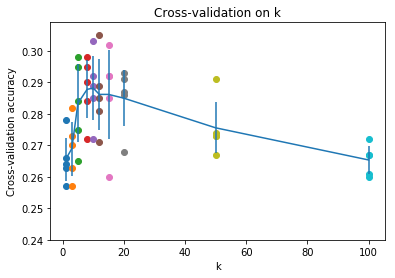

In [30]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [31]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 1000 correct => accuracy: 0.137000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*:

*Your explanation*: